In [1]:
import os
import json
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from model import Detector
from PIL import Image
from torch.utils.data import DataLoader
from utils import file_format_counter
from dataloader import SARDet
from torchsummary import summary

Data Exploration

In [2]:
data_dir = "/home/hasanmog/CNN-VS-ViT/Datasets/SARDet"
train = os.listdir(os.path.join(data_dir + '/train'))
val = os.listdir(os.path.join(data_dir + '/val'))
len(train) , len(val)

(94493, 10492)

In [3]:
random.seed(50)
random.shuffle(train)
test = train[70000:]
train = train[:70000]
len(train) , len(test)

(70000, 24493)

<PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256 at 0x7F023D2424A0>


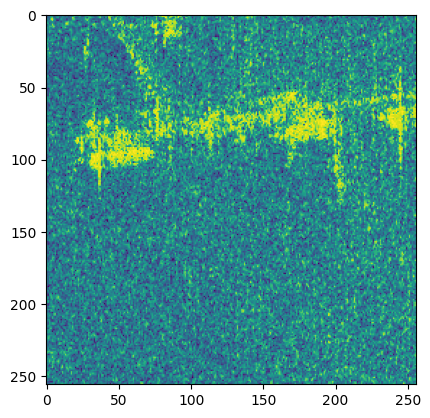

In [4]:
index = 6000
img = Image.open(os.path.join(data_dir+'/train/'+train[index]))
print(img)
plt.imshow(img)

In [5]:
png , jpg ,bmp = file_format_counter(train)         
print(f"train_set: png={png} , jpg={jpg} , bmp={bmp}")
png , jpg ,bmp = file_format_counter(val)         
print(f"val_set: png={png} , jpg={jpg} , bmp={bmp}")
png , jpg ,bmp = file_format_counter(test)         
print(f"test_set: png={png} , jpg={jpg} , bmp={bmp}")      

train_set: png=10893 , jpg=58508 , bmp=599
val_set: png=1834 , jpg=8614 , bmp=44
test_set: png=3771 , jpg=20526 , bmp=196


In [6]:
print(train[0])

0044438.jpg


In [7]:
train_json = os.path.join(data_dir+'/train.json')
val_json = os.path.join(data_dir+'/val.json')

with open(train_json , 'r') as file:
    train_anno = json.load(file)
    
train_anno.keys() , train_anno['images'][0] , train_anno['annotations'][0] , train_anno['categories']

(dict_keys(['images', 'annotations', 'categories']),
 {'file_name': '0028177.jpg', 'height': 512, 'width': 512, 'id': 0},
 {'area': 2394.0,
  'iscrowd': 0,
  'image_id': 0,
  'bbox': [334.0, 188.0, 38.0, 63.0],
  'category_id': 0,
  'id': 0,
  'ignore': 0,
  'segmentation': []},
 [{'id': 0, 'name': 'ship'},
  {'id': 1, 'name': 'aircraft'},
  {'id': 2, 'name': 'car'},
  {'id': 3, 'name': 'tank'},
  {'id': 4, 'name': 'bridge'},
  {'id': 5, 'name': 'harbor'}])

In [8]:
train_set = SARDet(data_dir= data_dir , imgs = train , mode = 'train')
val_set = SARDet(data_dir= data_dir , imgs = val , mode = 'val')
test_set = SARDet(data_dir= data_dir , imgs = test , mode = 'test')
len(train_set) , len(val_set) , len(test_set)

(70000, 10492, 24493)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 8

In [10]:
train_loader = DataLoader(dataset = train_set , batch_size = BATCH_SIZE , shuffle = True)
val_loader = DataLoader(dataset = val_set , batch_size = BATCH_SIZE , shuffle = True)
test_loader = DataLoader(dataset = test_set , batch_size = BATCH_SIZE , shuffle = False)
len(train_loader),len(val_loader),len(test_loader)

(8750, 1312, 3062)

In [11]:
sample = val_set[1100]

image size :  (512, 512, 3)


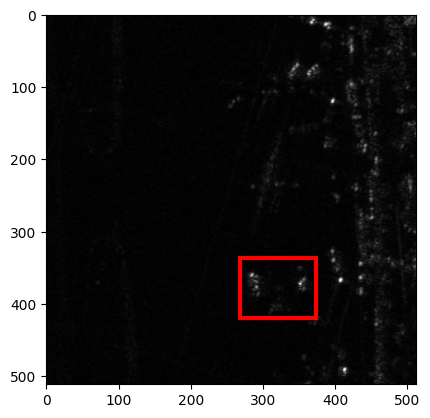

In [12]:
image = sample['image_tensor'].numpy()
image = np.transpose(image , (1 , 2 , 0))
print("image size : " , image.shape)

fig , ax = plt.subplots(1)
ax.imshow(image , cmap='viridis')

for i in range(len(sample['bboxes'])):
    box = sample['bboxes'][i]
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=3, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    
plt.show()

In [13]:
model = Detector().to(device)
summary(model , input_size=(3,256 , 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
              ReLU-2         [-1, 16, 254, 254]               0
       BatchNorm2d-3         [-1, 16, 254, 254]              32
            Conv2d-4         [-1, 32, 126, 126]           4,640
              ReLU-5         [-1, 32, 126, 126]               0
       BatchNorm2d-6         [-1, 32, 126, 126]              64
            Conv2d-7         [-1, 64, 124, 124]          18,496
              ReLU-8         [-1, 64, 124, 124]               0
       BatchNorm2d-9         [-1, 64, 124, 124]             128
           Conv2d-10          [-1, 128, 61, 61]          73,856
             ReLU-11          [-1, 128, 61, 61]               0
      BatchNorm2d-12          [-1, 128, 61, 61]             256
           Conv2d-13          [-1, 256, 59, 59]         295,168
             ReLU-14          [-1, 256,

In [14]:
input_array = np.random.randint(0, 1, (800, 800, 3))  # Generate a random 800x800 image with 3 channels (RGB)
input_tensor = torch.from_numpy(input_array).float()  # Convert to float tensor
print(input_tensor.shape)
input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)  

input_tensor = input_tensor.to(device)
# Pass the input tensor through the model
outputs = model(input_tensor)  # Ensure model is in evaluation mode if not training: model.eval()
outputs[: , : , 0 , 0] , outputs.shape

torch.Size([800, 800, 3])


(tensor([[ 0.0044, -0.0104,  0.0068, -0.0031, -0.0018, -0.0139,  0.0018,  0.0005,
           0.0028,  0.0131, -0.0107, -0.0136,  0.0025, -0.0120, -0.0043, -0.0042,
          -0.0073,  0.0032,  0.0044, -0.0147, -0.0079,  0.0065,  0.0040,  0.0122,
          -0.0049, -0.0020,  0.0117, -0.0119, -0.0027, -0.0072,  0.0085,  0.0003,
           0.0114,  0.0131,  0.0025,  0.0061,  0.0129, -0.0113,  0.0083, -0.0083,
           0.0129,  0.0089,  0.0134,  0.0012,  0.0088, -0.0012,  0.0122, -0.0127,
           0.0042,  0.0065,  0.0094, -0.0045,  0.0021,  0.0091,  0.0048]],
        device='cuda:0', grad_fn=<SelectBackward0>),
 torch.Size([1, 55, 97, 97]))

In [15]:
from postprocessing import convert_to_mins_maxes , non_max_suppression , process_boxes
from model import decode_outputs

boxes , object , class_scores = decode_outputs(outputs) 
boxes = process_boxes(boxes , image , convert_to_mins_maxes)
iou_threshold = 0.5
score_threshold = 0.2
picked_boxes, picked_scores, picked_classes = non_max_suppression(boxes, object, class_scores)

MemoryError: Unable to allocate 1.32 TiB for an array with shape (88529281, 512, 4) and data type float64